# Simulation

Run these functions in your Jupyter Book:

# For GIF generation:
create_gif_animation(save_as_gif=True)

# For parameter comparison:
create_parameter_comparison()

# For complete demo:
main_demo()


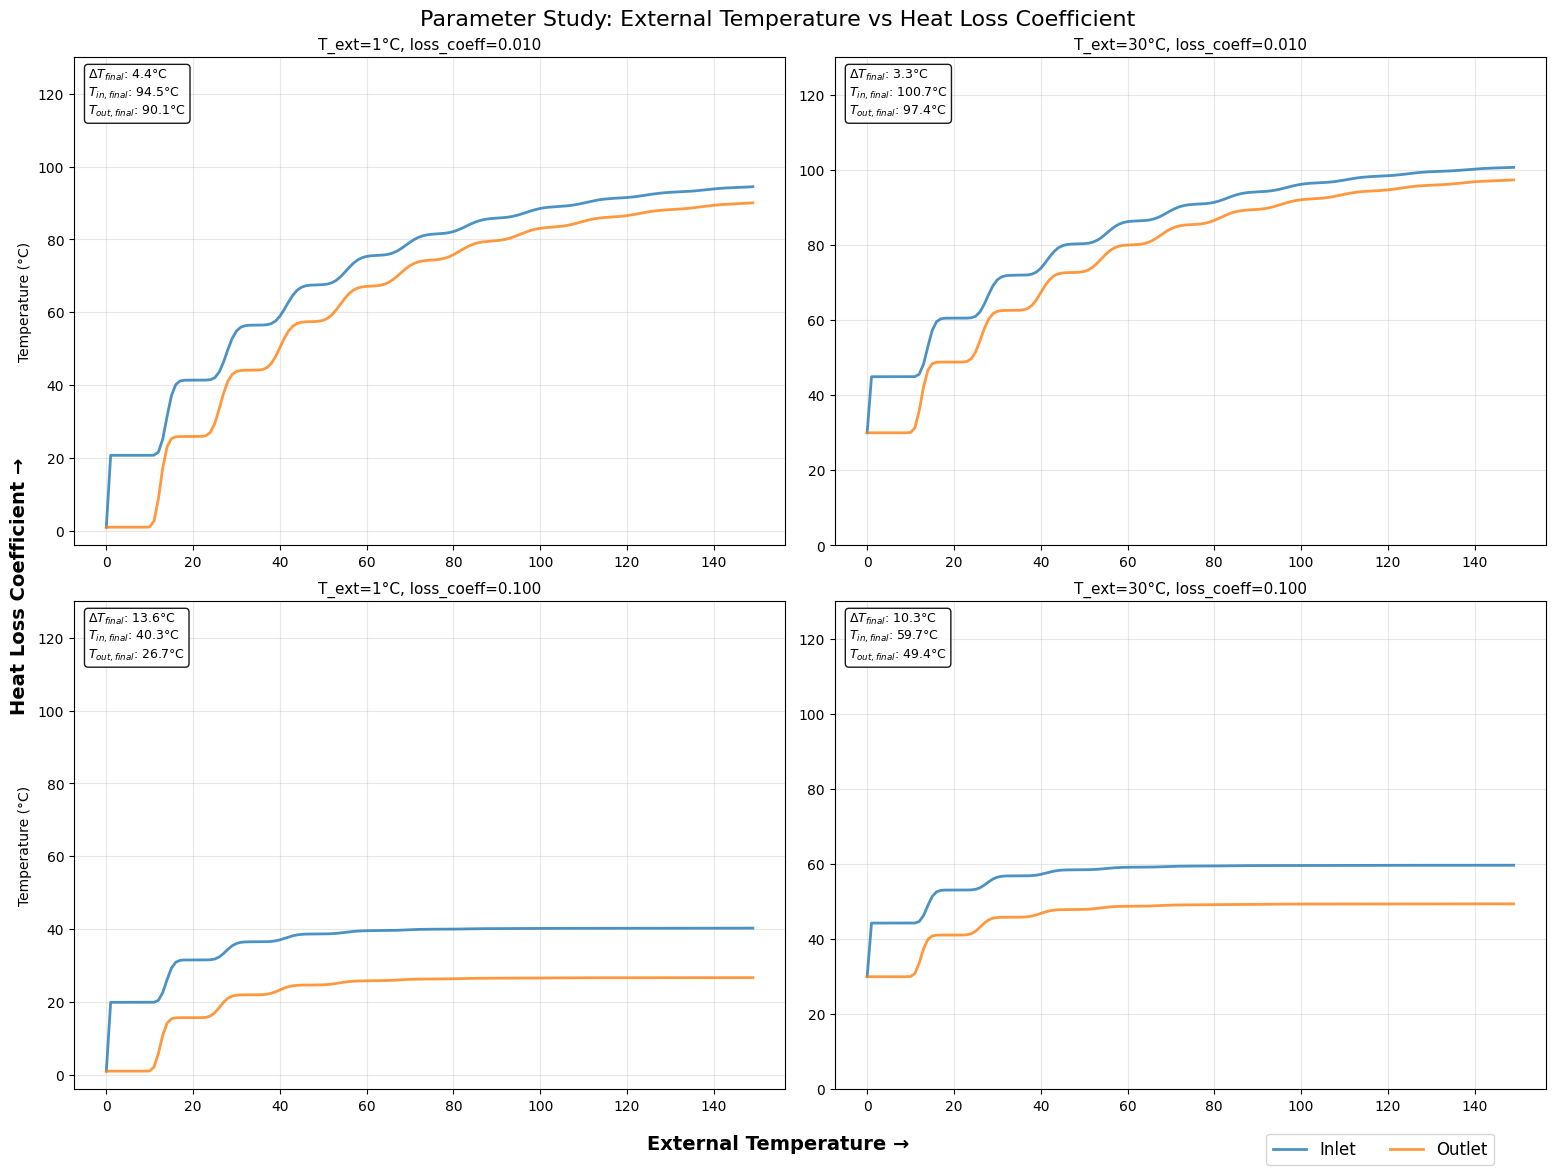

ValueError: 0.01 is not in list

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize
import numpy as np


def propagate_pipe(pipe_temperature: list[float]):
    T_end = pipe_temperature.pop(-1)  # Remove the last element
    pipe_temperature.insert(0, T_end)  # Insert it at the beginning


def update_pipe(pipe_temperature, loss_coeff, T_ext, T_heater, heat_coeff):
    N = len(pipe_temperature)
    new_temperatures = pipe_temperature.copy()

    for i in range(1, N - 1):
        new_temperatures[i] = (
            pipe_temperature[i - 1]
            + pipe_temperature[i]
            + loss_coeff * T_ext
        ) / (2.0 + loss_coeff)

    # Update the heater end
    new_temperatures[0] = (heat_coeff * T_heater + pipe_temperature[0]) / (
        heat_coeff + 1
    )

    return new_temperatures


def create_gif_animation(save_as_gif=True, filename="pipe_simulation.gif"):
    """
    Create animation from your original code and optionally save as GIF
    """
    # Default parameters from your original code
    T_ext = 7
    N = 20
    T_heater = 120
    t_max = 150
    loss_coeff = 2e-2
    heat_coeff = 0.5

    pipe_temperature = [T_ext] * N

    # Setup for plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # First subplot: Pipe temperature visualization
    bar_container = ax1.bar(
        range(len(pipe_temperature)), pipe_temperature, color="blue"
    )
    ax1.set_ylim(0, 100)
    ax1.set_title("Pipe Temperature Distribution")
    ax1.set_xlabel("Pipe Element")
    ax1.set_ylabel("Temperature (°C)")

    # Normalization for color mapping
    norm = Normalize(vmin=T_ext, vmax=100)

    # Second subplot: Temperature at both ends over time
    times = []
    T_start_history = []
    T_end_history = []
    (line_start,) = ax2.plot([], [], linewidth=2, label="$T_{inlet}$")
    (line_end,) = ax2.plot([], [], linewidth=2, label="$T_{outlet}$")
    ax2.set_xlim(0, t_max)
    ax2.set_ylim(T_ext - 5, 100)
    ax2.set_title("Temperature at Pipe Ends Over Time")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Temperature (°C)")
    ax2.grid()
    ax2.legend()

    def init():
        # Initialize the bar colors
        for bar, temp in zip(bar_container, pipe_temperature):
            bar.set_color(plt.cm.jet(norm(temp)))
        line_start.set_data([], [])
        line_end.set_data([], [])
        return list(bar_container) + [line_start, line_end]

    def animate(t):
        nonlocal pipe_temperature, times, T_start_history, T_end_history
        # Update the pipe temperature
        pipe_temperature = update_pipe(
            pipe_temperature, loss_coeff, T_ext, T_heater, heat_coeff
        )
        propagate_pipe(pipe_temperature)

        # Update bar heights and colors
        for bar, temp in zip(bar_container, pipe_temperature):
            bar.set_height(temp)
            bar.set_color(plt.cm.jet(norm(temp)))

        # Record temperatures at both ends
        T_start = pipe_temperature[2]
        T_end = pipe_temperature[0]
        times.append(t)
        T_start_history.append(T_start)
        T_end_history.append(T_end)

        # Update the line plots
        line_start.set_data(times, T_start_history)
        line_end.set_data(times, T_end_history)

        # Adjust the x-axis if necessary
        if t >= ax2.get_xlim()[1]:
            ax2.set_xlim(0, t + t_max * 0.1)

        return list(bar_container) + [line_start, line_end]

    ani = animation.FuncAnimation(
        fig,
        animate,
        frames=t_max,
        init_func=init,
        blit=False,
        interval=100,
        repeat=False,
    )

    plt.tight_layout()
    
    if save_as_gif:
        print(f"Saving animation as {filename}...")
        ani.save(filename, writer='pillow', fps=10, dpi=80)
        print(f"✅ GIF saved as {filename}")
    
    plt.show()
    return ani


def run_single_simulation(N, T_ext, T_heater, t_max, loss_coeff, heat_coeff):
    """Run a single simulation and return final results"""
    pipe_temperature = [T_ext] * N
    
    # Storage for time series
    times = []
    T_start_history = []
    T_end_history = []
    
    for t in range(t_max):
        # Update the pipe temperature
        pipe_temperature = update_pipe(
            pipe_temperature, loss_coeff, T_ext, T_heater, heat_coeff
        )
        propagate_pipe(pipe_temperature)
        
        # Record temperatures
        T_start = pipe_temperature[2] if len(pipe_temperature) > 2 else pipe_temperature[0]
        T_end = pipe_temperature[0]
        times.append(t)
        T_start_history.append(T_start)
        T_end_history.append(T_end)
    
    return {
        'times': times,
        'T_start_history': T_start_history,
        'T_end_history': T_end_history,
        'final_pipe_temp': pipe_temperature,
        'steady_state_inlet': T_start_history[-1],
        'steady_state_outlet': T_end_history[-1],
        'temperature_difference': T_start_history[-1] - T_end_history[-1]
    }


def create_parameter_comparison():
    """
    Create 4x4 comparison plot varying external temperature and heat loss coefficient
    """
    # Parameter ranges
    T_ext_values = [1, 30]  # External temperatures
    loss_coeff_values = [0.01,0.1]  # Heat loss coefficients
    
    # Fixed parameters
    N = 20
    T_heater = 120
    t_max = 150
    heat_coeff = 0.5
    
    # Create the 4x4 plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Parameter Study: External Temperature vs Heat Loss Coefficient', 
                 fontsize=16, y=0.98)
    
    # Store results for summary
    results_summary = []
    
    for i, loss_coeff in enumerate(loss_coeff_values):
        for j, T_ext in enumerate(T_ext_values):
            ax = axes[i, j]
            
            # Run simulation
            results = run_single_simulation(N, T_ext, T_heater, t_max, loss_coeff, heat_coeff)
            
            # Plot time series
            ax.plot(results['times'], results['T_start_history'], 
                   linewidth=2, alpha=0.8, label='Inlet' if i==0 and j==0 else "")
            ax.plot(results['times'], results['T_end_history'], 
                   linewidth=2, alpha=0.8, label='Outlet' if i==0 and j==0 else "")
            
            # Formatting
            ax.set_title(f'T_ext={T_ext}°C, loss_coeff={loss_coeff:.3f}', fontsize=11)
            ax.grid(True, alpha=0.3)
            ax.set_ylim(min(T_ext - 5, 0), T_heater + 10)
            
            # Labels only on edges
            if i == 3:  # Bottom row
                ax.set_xlabel('Time Step')
            if j == 0:  # Left column
                ax.set_ylabel('Temperature (°C)')
            
            # Add steady-state info
            final_diff = results['temperature_difference']
            steady_inlet = results['steady_state_inlet']
            steady_outlet = results['steady_state_outlet']
            str = '$ΔT_{final}$'
            str_in= '$T_{in,final}$'
            str_out = '$T_{out,final}$'
            info_text = f'{str}: {final_diff:.1f}°C\n{str_in}: {steady_inlet:.1f}°C\n{str_out}: {steady_outlet:.1f}°C'
            ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
                   verticalalignment='top', fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
            
            # Store for summary
            results_summary.append({
                'T_ext': T_ext,
                'loss_coeff': loss_coeff,
                'temperature_difference': final_diff,
                'steady_inlet': steady_inlet,
                'steady_outlet': steady_outlet
            })
    
    # Add overall legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:  # Only if we have legend items
        fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.8, 0.01), 
                  ncol=2, fontsize=12)
    
    # Add parameter labels on the sides
    fig.text(0.02, 0.5, 'Heat Loss Coefficient →', rotation=90, 
             verticalalignment='center', fontsize=14, weight='bold')
    fig.text(0.5, 0.03, 'External Temperature →', horizontalalignment='center', 
             fontsize=14, weight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94, bottom=0.08, left=0.06, right=0.98)
    plt.savefig('param_comparison.pdf')
    plt.show()
   
    return results_summary


def create_summary_heatmap(results_summary=None):
    """
    Create heatmaps showing the effect of parameters on key metrics
    """
    if results_summary is None:
        # Run the comparison to get data
        print("Running parameter comparison to generate data...")
        results_summary = create_parameter_comparison()
    
    # Convert to arrays for heatmap
    T_ext_values = [1, 10, 100]  # External temperatures
    loss_coeff_values = [0.005,0.1, 1.0]  # Heat loss coefficients
    # Initialize arrays
    temp_diff_matrix = np.zeros((3, 3))
    inlet_temp_matrix = np.zeros((3, 3))
    outlet_temp_matrix = np.zeros((3, 3))
    
    # Fill matrices
    for result in results_summary:
        i = loss_coeff_values.index(result['loss_coeff'])
        j = T_ext_values.index(result['T_ext'])
        temp_diff_matrix[i, j] = result['temperature_difference']
        inlet_temp_matrix[i, j] = result['steady_inlet']
        outlet_temp_matrix[i, j] = result['steady_outlet']
    
    # Create heatmap plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Temperature difference heatmap
    im1 = ax1.imshow(temp_diff_matrix, cmap='RdYlBu_r', aspect='auto')
    ax1.set_title('Steady-State Temperature Difference (°C)')
    ax1.set_xlabel('External Temperature (°C)')
    ax1.set_ylabel('Heat Loss Coefficient')
    ax1.set_xticks(range(3))
    ax1.set_xticklabels(T_ext_values)
    ax1.set_yticks(range(3))
    ax1.set_yticklabels([f'{x:.3f}' for x in loss_coeff_values])
    
    # Add text annotations
    for i in range(3):
        for j in range(3):
            ax1.text(j, i, f'{temp_diff_matrix[i, j]:.1f}', 
                    ha='center', va='center', color='white', weight='bold')
    
    plt.colorbar(im1, ax=ax1, shrink=0.8)
    
    # Inlet temperature heatmap
    im2 = ax2.imshow(inlet_temp_matrix, cmap='Reds', aspect='auto')
    ax2.set_title('Steady-State Inlet Temperature (°C)')
    ax2.set_xlabel('External Temperature (°C)')
    ax2.set_ylabel('Heat Loss Coefficient')
    ax2.set_xticks(range(3))
    ax2.set_xticklabels(T_ext_values)
    ax2.set_yticks(range(3))
    ax2.set_yticklabels([f'{x:.3f}' for x in loss_coeff_values])
    
    for i in range(3):
        for j in range(3):
            ax2.text(j, i, f'{inlet_temp_matrix[i, j]:.0f}', 
                    ha='center', va='center', color='white', weight='bold')
    
    plt.colorbar(im2, ax=ax2, shrink=0.8)
    
    # Outlet temperature heatmap
    im3 = ax3.imshow(outlet_temp_matrix, cmap='Blues', aspect='auto')
    ax3.set_title('Steady-State Outlet Temperature (°C)')
    ax3.set_xlabel('External Temperature (°C)')
    ax3.set_ylabel('Heat Loss Coefficient')
    ax3.set_xticks(range(3))
    ax3.set_xticklabels(T_ext_values)
    ax3.set_yticks(range(3))
    ax3.set_yticklabels([f'{x:.3f}' for x in loss_coeff_values])
    
    for i in range(3):
        for j in range(3):
            ax3.text(j, i, f'{outlet_temp_matrix[i, j]:.0f}', 
                    ha='center', va='center', color='white', weight='bold')
    
    plt.colorbar(im3, ax=ax3, shrink=0.8)
    
    plt.tight_layout()
    plt.show()


def main_demo():
    """
    Main demonstration function showing both parts
    """
    print("🔥 Pipe Temperature Simulation - Two-Part Analysis")
    print("=" * 60)
    print()
    print("Part 1: Creating GIF animation from original code...")
    print("(This will take a moment to generate)")
    
    # Create GIF
    create_gif_animation(save_as_gif=True, filename="pipe_simulation.gif")
    
    print()
    print("Part 2: Creating 4x4 parameter comparison...")
    print("Varying external temperature (0-25°C) and heat loss coefficient (0.005-0.1)")
    
    # Create comparison plot
    results = create_parameter_comparison()
    
    print()
    print("Part 3: Creating summary heatmaps...")
    create_summary_heatmap(results)
    
    print()
    print("✅ Complete! You now have:")
    print("   - pipe_simulation.gif (animated visualization)")
    print("   - 4x4 parameter comparison plot")
    print("   - Summary heatmaps")


if __name__ == "__main__":
    print("Run these functions in your Jupyter Book:")
    print()
    print("# For GIF generation:")
    print("create_gif_animation(save_as_gif=True)")
    print()
    print("# For parameter comparison:")
    print("create_parameter_comparison()")
    print()
    print("# For complete demo:")
    print("main_demo()")
    # create_gif_animation(save_as_gif=True)
    results = create_parameter_comparison()
    
    create_summary_heatmap(results)